# Pipeline et modèle

In [551]:
import pandas as pd
import numpy as np

import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder,PolynomialFeatures,FunctionTransformer,StandardScaler
from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression,Lasso
from sklearn.model_selection import GridSearchCV,learning_curve,StratifiedKFold
from sklearn.metrics import mean_absolute_error,make_scorer
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

import pickle

In [552]:
df = pd.read_csv("../data/AmesHousing.csv")
df_anormal = df[df["Sale Condition"]=="Abnorml"]
df = df[df["Sale Condition"]!="Abnorml"]
ngbd=list(df.Neighborhood.value_counts()[df.Neighborhood.value_counts()>3].index)
df=df.loc[df['Neighborhood'].isin(ngbd)]


In [553]:
numeric_features = ["Year Built", "1st Flr SF", "Gr Liv Area", "Garage Area", "Overall Qual", "Full Bath"]
ordinal_features = [ "Exter Qual",  "Kitchen Qual"]
cat_feature = ["Foundation","Neighborhood"]
all_col = numeric_features.copy()
all_col.extend(ordinal_features)
all_col.extend(cat_feature)

In [554]:
def plot_scatter_with_saleprice(df):
    # Calculate the number of rows and columns required for subplots
    num_rows = int(len(df.columns) / 4) + (len(df.columns) % 4 > 0)
    num_cols = 4

    # Creating subplots for numeric variables against 'SalePrice'
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5*num_rows))
    axes = axes.flatten()

    for i, col in enumerate(df.columns):
        # Skip the scatter plot when y='SalePrice' and x='SalePrice'
        
        sns.scatterplot(x=col, y='SalePrice', data=df, ax=axes[i])
        axes[i].set_ylabel("SalePrice")

        # # Hide any empty subplots if the number of columns is not a multiple of 4
        # if i >= len(df.columns) - (len(df.columns) % 4):
        #     axes[i].axis('off')

    plt.tight_layout()
    plt.show()

In [555]:
df = df[(df["Gr Liv Area"]<4000) | (df["SalePrice"]>300000)]
df = df[df["1st Flr SF"]<3500]
# df = df[df["Garage Area"]<1150]

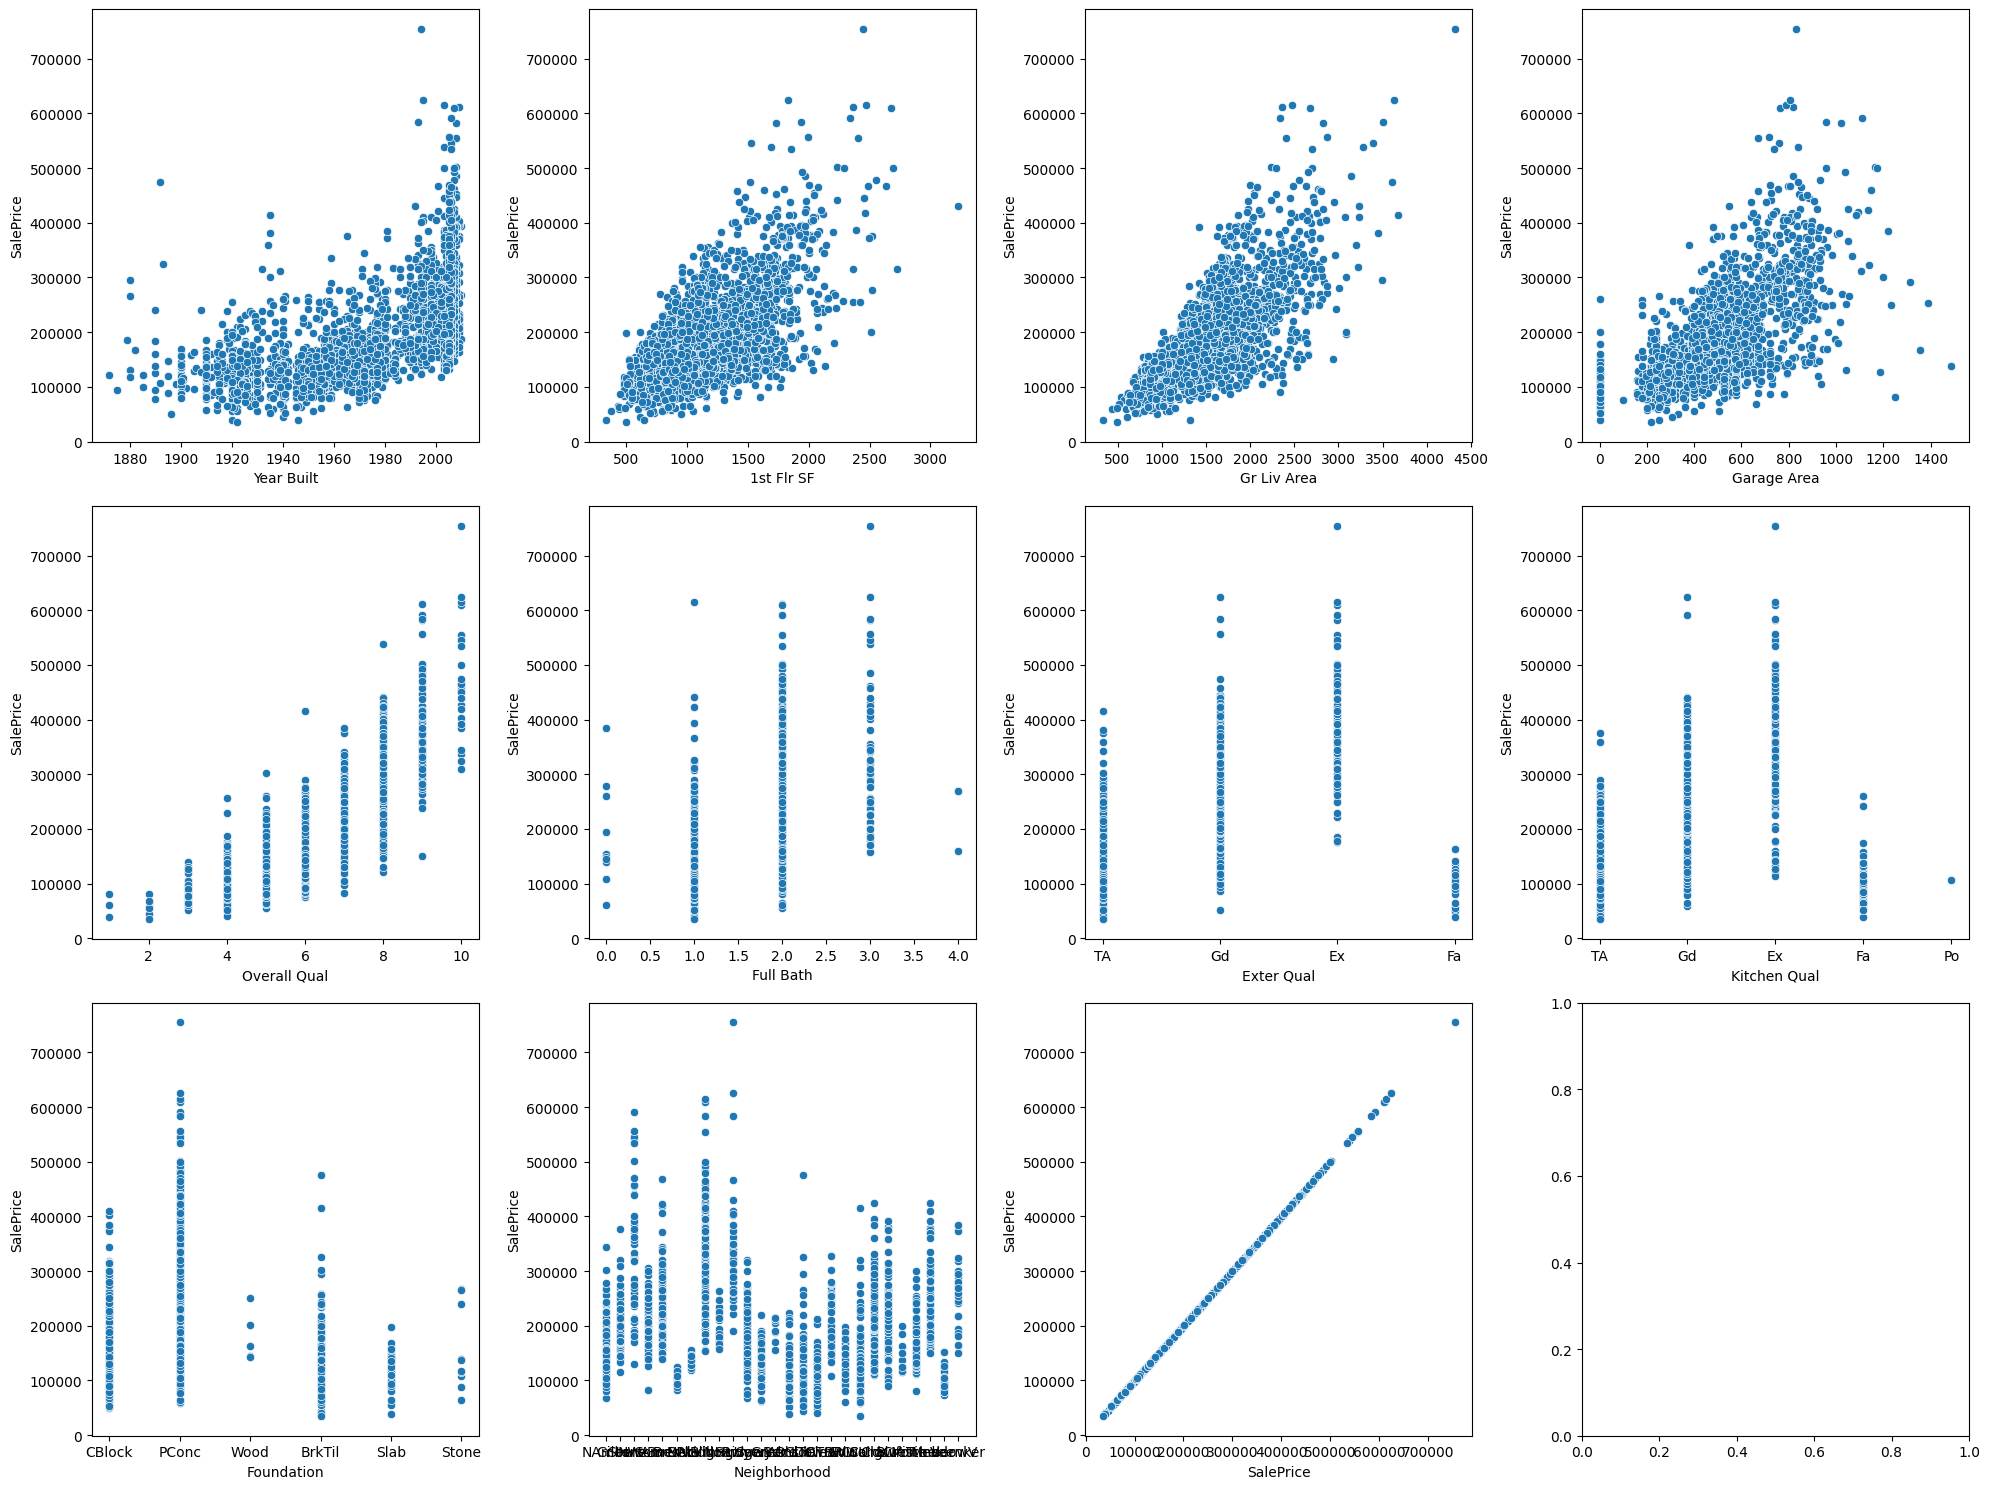

In [556]:
plot_scatter_with_saleprice(pd.concat([df[all_col],df["SalePrice"]],axis=1))

Il ne faut selectionner que 10 features, on supprime Neighborhood qui est trop complexe à traiter, ainsi que bsmt Qual et garage Finish qui sont trop proches d'autres variables

In [557]:


X = df[all_col]
y = np.log(df[["SalePrice"]])


X_anormal = df_anormal[all_col]
y_anormal = np.log(df_anormal[["SalePrice"]])



In [558]:
df.shape

(2733, 82)

In [559]:
X.columns 

Index(['Year Built', '1st Flr SF', 'Gr Liv Area', 'Garage Area',
       'Overall Qual', 'Full Bath', 'Exter Qual', 'Kitchen Qual', 'Foundation',
       'Neighborhood'],
      dtype='object')

In [560]:
X.columns = ['Year_Built',  '1st_Flr_SF', 'Gr_Liv_Area','Garage_Area', 'Overall_Qual', 'Full_Bath', 'Exter_Qual',
       'Kitchen_Qual', "Foundation",'Neighborhood']
X_anormal.columns=['Year_Built',  '1st_Flr_SF', 'Gr_Liv_Area','Garage_Area', 'Overall_Qual', 'Full_Bath', 'Exter_Qual',
       'Kitchen_Qual', "Foundation",'Neighborhood']

In [579]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=X["Overall_Qual"] ,random_state=42)

In [580]:

exter_cat = [ 'Po', 'Fa','TA', 'Gd','Ex']
kitchen_cat = [ 'Po', 'Fa','TA', 'Gd',"Ex"]

ordinal_transformer = OrdinalEncoder(categories=[exter_cat, kitchen_cat])

categorical_transformer = OneHotEncoder()

In [614]:
standar_transformer = StandardScaler()
poly_transformer = PolynomialFeatures(2,interaction_only=True)

numeric_imputer = KNNImputer() 
numeric_transformer = Pipeline([
    ('imputer', numeric_imputer),
    ('standar', standar_transformer),   
])
numeric_transformer_poly = Pipeline([
    ('imputer', numeric_imputer),
    ('standar', standar_transformer),
    ('poly', poly_transformer),
    
])

exter_cat = [ 'Po', 'Fa','TA', 'Gd','Ex']
kitchen_cat = [ 'Po', 'Fa','TA', 'Gd',"Ex"]

ordinal_transformer = OrdinalEncoder(categories=[exter_cat, kitchen_cat])

categorical_transformer = OneHotEncoder(handle_unknown="ignore")

In [633]:
numeric_features = [ "Full_Bath"]
numeric_features_poly = ["1st_Flr_SF","Gr_Liv_Area","Overall_Qual","Year_Built","Garage_Area"]

ordinal_features = [ "Exter_Qual",  "Kitchen_Qual"]
cat_feature = [ "Foundation","Neighborhood"]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('num_poly', numeric_transformer_poly, numeric_features_poly),
        ('ord', ordinal_transformer, ordinal_features),
        ('cat', categorical_transformer, cat_feature),
    ]
)



In [634]:
reg = Lasso(alpha=0.1,random_state=42)

In [635]:
skf = StratifiedKFold(n_splits=3,random_state=42, shuffle=True)


In [636]:
pipe = Pipeline([
     ('preprocessor', preprocessor),
     ('reg', reg)
])

parameters = {"reg__alpha":np.linspace(1.0e-5,1.0e-4,1000)}
scorer = make_scorer(mean_absolute_error, greater_is_better=False)
skf = StratifiedKFold(n_splits=3,random_state=42, shuffle=True)

grid_src = GridSearchCV(estimator=pipe, param_grid=parameters,scoring=scorer,cv=skf.split(X_train, X_train["Overall_Qual"]),n_jobs=-1,verbose=0)
grid_src.fit(X_train, y_train)

pipe.set_params(**grid_src.best_params_)
print(grid_src.best_params_)
best=grid_src.best_params_


/home/apprenant/miniconda3/envs/e2/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(
/home/apprenant/miniconda3/envs/e2/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.210e-02, tolerance: 2.282e-02
  model = cd_fast.enet_coordinate_descent(
/home/apprenant/miniconda3/envs/e2/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.012e-02, tolerance: 2.282e-02
  model = cd_fast.enet_coordinate_descent(
/home/apprenant/miniconda3/envs/e2/lib/pyt

/home/apprenant/miniconda3/envs/e2/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.866e-02, tolerance: 2.282e-02
  model = cd_fast.enet_coordinate_descent(
/home/apprenant/miniconda3/envs/e2/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.601e-02, tolerance: 2.282e-02
  model = cd_fast.enet_coordinate_descent(
/home/apprenant/miniconda3/envs/e2/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider

{'reg__alpha': 5.3153153153153155e-05}


In [637]:
best

{'reg__alpha': 5.3153153153153155e-05}

In [638]:
pipe.fit(X_train, y_train)
pipe.score(X_test,y_test)

predict_train  = pipe.predict(X_train)
predict_test  = pipe.predict(X_test)
predict_anormal  = pipe.predict(X_anormal)
# Root Mean Squared Error on train and test date
print('MAE on train data: ', mean_absolute_error(np.exp(y_train), np.exp(predict_train)))
print('MAE on test data: ',  mean_absolute_error(np.exp(y_test), np.exp(predict_test)))
print('MAE on anormal data: ',  mean_absolute_error(np.exp(y_anormal), np.exp(predict_anormal)))

MAE on train data:  15819.578575378353
MAE on test data:  16788.234642941905
MAE on anormal data:  24744.11268473885


In [639]:
print(pipe.score(X_train,y_train))
print(pipe.score(X_test,y_test))
print(pipe.score(X_anormal,y_anormal))

0.9027565966954874
0.8832767833928082
0.6328398636129173


In [640]:
filename = '../real_estate_app/main_app/static/models/finalized_model.pkl'
pickle.dump(pipe, open(filename, 'wb'))

In [641]:
pipe[:-1].get_feature_names_out()

array(['num__Full_Bath', 'num_poly__1', 'num_poly__1st_Flr_SF',
       'num_poly__Gr_Liv_Area', 'num_poly__Overall_Qual',
       'num_poly__Year_Built', 'num_poly__Garage_Area',
       'num_poly__1st_Flr_SF Gr_Liv_Area',
       'num_poly__1st_Flr_SF Overall_Qual',
       'num_poly__1st_Flr_SF Year_Built',
       'num_poly__1st_Flr_SF Garage_Area',
       'num_poly__Gr_Liv_Area Overall_Qual',
       'num_poly__Gr_Liv_Area Year_Built',
       'num_poly__Gr_Liv_Area Garage_Area',
       'num_poly__Overall_Qual Year_Built',
       'num_poly__Overall_Qual Garage_Area',
       'num_poly__Year_Built Garage_Area', 'ord__Exter_Qual',
       'ord__Kitchen_Qual', 'cat__Foundation_BrkTil',
       'cat__Foundation_CBlock', 'cat__Foundation_PConc',
       'cat__Foundation_Slab', 'cat__Foundation_Stone',
       'cat__Foundation_Wood', 'cat__Neighborhood_Blmngtn',
       'cat__Neighborhood_Blueste', 'cat__Neighborhood_BrDale',
       'cat__Neighborhood_BrkSide', 'cat__Neighborhood_ClearCr',
       'ca

In [642]:
pipe[-1].coef_

array([-0.01205553,  0.        ,  0.05168458,  0.13710475,  0.0918201 ,
        0.05580098,  0.04532339, -0.01630274,  0.02789463,  0.01016911,
       -0.01278582, -0.00288865,  0.00343298,  0.00636922, -0.03714757,
        0.00480034,  0.00610855,  0.03644384,  0.058108  ,  0.        ,
        0.05130632,  0.04411268, -0.1384499 , -0.01201062, -0.02320523,
       -0.03667239, -0.05510519, -0.1771581 , -0.00284746,  0.13683599,
        0.00693742,  0.15587114, -0.0516451 ,  0.04197138,  0.        ,
       -0.10931839, -0.22770258,  0.02949161, -0.00622002, -0.04232925,
       -0.01003687,  0.06844542,  0.06025429, -0.06206814, -0.0482537 ,
        0.00491963, -0.04574484,  0.02549502,  0.10785359,  0.07431381,
        0.09805225])

In [643]:
print(f"La valeur de l'intercept est : {pipe[-1].intercept_[0]}")

La valeur de l'intercept est : 11.776851813972248


In [644]:
pd.DataFrame(dict(zip(pipe[:-1].get_feature_names_out(), pipe[-1].coef_)),index=["Coef"]).T.sort_values(by="Coef",ascending=False)

,Coef
cat__Neighborhood_Crawfor,0.155871
num_poly__Gr_Liv_Area,0.137105
cat__Neighborhood_ClearCr,0.136836
cat__Neighborhood_StoneBr,0.107854
cat__Neighborhood_Veenker,0.098052
num_poly__Overall_Qual,0.091820
cat__Neighborhood_Timber,0.074314
cat__Neighborhood_NoRidge,0.068445
cat__Neighborhood_NridgHt,0.060254
ord__Kitchen_Qual,0.058108


In [645]:

dico = {'Year_Built': 2015, 'Foundation': "CBlock", '1st_Flr_SF': 30, 'Gr_Liv_Area': 100, 'Garage_Area': 1, 'Overall_Qual': 1, 'Full_Bath': 1, 'Exter_Qual': 'Po', 'Kitchen_Qual': 'Po', 'Neighborhood': 'Blmngtn'}

In [646]:
np.exp(pipe.predict(pd.DataFrame(dico,index=[0])))

array([68520.67031442])

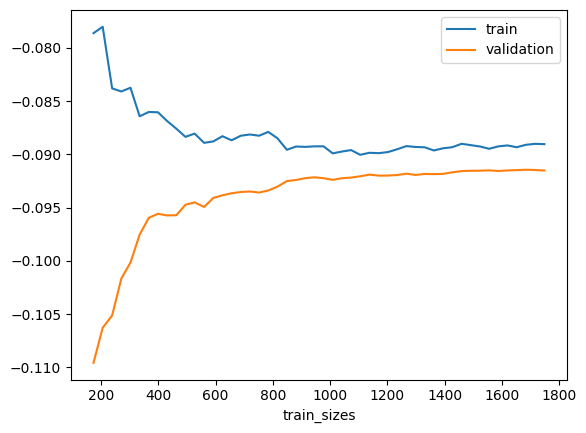

In [647]:
train_sizes, train_scores, test_scores = learning_curve(pipe,X_train,y_train,cv=5,train_sizes=np.linspace(0.1, 1.0, 50),scoring=scorer,n_jobs=-1) 
plt.plot(train_sizes, train_scores.mean(axis=1), label='train')
plt.plot(train_sizes, test_scores.mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.legend()
plt.show()